<a href="https://colab.research.google.com/github/Sankoku/Human-Machine/blob/main/Lab_5_LM_Liashenko_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!pip install kagglehub
!pip install pandas numpy matplotlib seaborn

In [8]:
import re
import json
import os
from collections import Counter
import numpy as np
import pandas as pd
import kagglehub
from typing import Dict, List, Set, Tuple
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
class AutocorrectSystem:
    """
    Система автокорекції тексту на основі мінімальної відстані редагування
    """

    def __init__(self):
        self.vocab = set()
        self.word_count_dict = {}
        self.probs = {}
        self.letters = 'abcdefghijklmnopqrstuvwxyz'

    def load_arxiv_dataset(self, max_papers=1000):
        """
        Завантажує та обробляє датасет arXiv
        """
        print("Завантаження датасету arXiv...")
        path = kagglehub.dataset_download("Cornell-University/arxiv")

        # Читаємо JSON файл з метаданими статей
        json_file = os.path.join(path, "arxiv-metadata-oai-snapshot.json")

        texts = []
        count = 0

        with open(json_file, 'r', encoding='utf-8') as f:
            for line in f:
                if count >= max_papers:
                    break

                try:
                    paper = json.loads(line)
                    # Використовуємо назву та анотацію статті
                    title = paper.get('title', '')
                    abstract = paper.get('abstract', '')
                    text = f"{title} {abstract}"
                    texts.append(text)
                    count += 1

                    if count % 100 == 0:
                        print(f"Оброблено {count} статей...")

                except json.JSONDecodeError:
                    continue

        print(f"Завантажено {len(texts)} статей")
        return ' '.join(texts)

    def process_text(self, text):
        """
        Обробляє текст та створює список слів у нижньому регістрі
        """
        # Перетворюємо в нижній регістр та видаляємо спеціальні символи
        text = text.lower()
        # Знаходимо всі слова (послідовності букв)
        words = re.findall(r'\b[a-z]+\b', text)
        return words

    def build_vocabulary(self, words):
        """
        Створює словник частотності слів
        """
        print("Створення словника...")
        self.word_count_dict = Counter(words)
        self.vocab = set(words)

        # Обчислюємо ймовірності
        total_count = sum(self.word_count_dict.values())
        self.probs = {word: count / total_count
                     for word, count in self.word_count_dict.items()}

        print(f"Словник містить {len(self.vocab)} унікальних слів")
        print(f"Загальна кількість слів: {total_count}")

    def delete_letter(self, word, verbose=False):
        """
        Видаляє одну літеру зі слова та повертає список усіх можливих варіантів
        """
        delete_l = []
        split_l = [(word[:i], word[i:]) for i in range(len(word))]
        delete_l = [L + R[1:] for L, R in split_l if R]

        if verbose:
            print(f"input word {word}, \nsplit_l = {split_l}, \ndelete_l = {delete_l}")

        return delete_l

    def switch_letter(self, word, verbose=False):
        """
        Міняє місцями дві сусідні літери та повертає всі можливі варіанти
        """
        switch_l = []
        split_l = [(word[:i], word[i:]) for i in range(len(word))]
        switch_l = [L + R[1] + R[0] + R[2:] for L, R in split_l if len(R) > 1]

        if verbose:
            print(f"Input word = {word} \nsplit_l = {split_l} \nswitch_l = {switch_l}")

        return switch_l

    def replace_letter(self, word, verbose=False):
        """
        Замінює одну літеру іншою та повертає всі можливі варіанти
        """
        replace_l = []
        split_l = [(word[:i], word[i:]) for i in range(len(word))]
        replace_l = [L + c + R[1:] for L, R in split_l if R for c in self.letters if L + c + R[1:] != word]

        if verbose:
            print(f"Input word = {word} \nsplit_l = {split_l} \nreplace_l = {replace_l}")

        return replace_l

    def insert_letter(self, word, verbose=False):
        """
        Вставляє одну літеру та повертає всі можливі варіанти
        """
        insert_l = []
        split_l = [(word[:i], word[i:]) for i in range(len(word) + 1)]
        insert_l = [L + c + R for L, R in split_l for c in self.letters]

        if verbose:
            print(f"Input word {word} \nsplit_l = {split_l} \ninsert_l = {insert_l}")

        return insert_l

    def edit_one_letter(self, word, allow_switches=True):
        """
        Повертає набір слів, які знаходяться на відстані одного редагування від вхідного слова
        """
        edit_set = set()
        edit_set.update(self.delete_letter(word))
        edit_set.update(self.replace_letter(word))
        edit_set.update(self.insert_letter(word))

        if allow_switches:
            edit_set.update(self.switch_letter(word))

        return edit_set

    def edit_two_letters(self, word, allow_switches=True):
        """
        Повертає набір слів, які знаходяться на відстані двох редагувань від вхідного слова
        """
        edit_set = set()
        for w in self.edit_one_letter(word, allow_switches):
            edit_set.update(self.edit_one_letter(w, allow_switches))

        return edit_set

    def get_corrections(self, word, n=3, verbose=False):
        """
        Повертає n найбільш ймовірних корекцій для введеного слова
        """
        suggestions = []

        # Якщо слово є у словнику, пропонуємо його
        if word in self.vocab:
            suggestions = [word]
        else:
            # Шукаємо слова на відстані одного редагування
            edit_one_set = self.edit_one_letter(word) & self.vocab
            if edit_one_set:
                suggestions = list(edit_one_set)
            else:
                # Шукаємо слова на відстані двох редагувань
                edit_two_set = self.edit_two_letters(word) & self.vocab
                if edit_two_set:
                    suggestions = list(edit_two_set)
                else:
                    # Якщо нічого не знайдено, повертаємо оригінальне слово
                    suggestions = [word]

        # Обчислюємо ймовірності для кожної пропозиції
        best_words = {}
        for w in suggestions:
            best_words[w] = self.probs.get(w, 0)

        # Повертаємо n слів з найвищими ймовірностями
        n_best = sorted(best_words.items(), key=lambda x: x[1], reverse=True)[:n]

        if verbose:
            print(f"Введене слово = {word}")
            print(f"Пропозиції = {suggestions}")
            print(f"Найкращі {n} варіантів: {n_best}")

        return n_best

    def min_edit_distance(self, source, target, ins_cost=1, del_cost=1, rep_cost=2):
        """
        Обчислює мінімальну відстань редагування між двома рядками
        """
        m = len(source)
        n = len(target)
        D = np.zeros((m+1, n+1), dtype=int)

        # Ініціалізація
        for row in range(m+1):
            D[row, 0] = row * del_cost

        for col in range(n+1):
            D[0, col] = col * ins_cost

        # Заповнення матриці динамічного програмування
        for row in range(1, m+1):
            for col in range(1, n+1):
                r_cost = rep_cost
                if source[row-1] == target[col-1]:
                    r_cost = 0

                D[row, col] = min(
                    D[row-1, col] + del_cost,      # видалення
                    D[row, col-1] + ins_cost,      # вставка
                    D[row-1, col-1] + r_cost       # заміна
                )

        return D, D[m, n]

    def evaluate_system(self, test_cases):
        """
        Оцінює точність системи автокорекції
        """
        correct_predictions = 0
        total_predictions = 0

        results = []

        for incorrect_word, correct_word in test_cases:
            corrections = self.get_corrections(incorrect_word, n=1)

            if corrections:
                predicted_word = corrections[0][0]
                is_correct = predicted_word == correct_word

                if is_correct:
                    correct_predictions += 1

                results.append({
                    'incorrect': incorrect_word,
                    'correct': correct_word,
                    'predicted': predicted_word,
                    'is_correct': is_correct,
                    'probability': corrections[0][1]
                })

            total_predictions += 1

        accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0

        return accuracy, results

    def plot_vocabulary_stats(self):
        """
        Візуалізує статистику словника
        """
        # Топ-20 найчастіших слів
        top_words = dict(self.word_count_dict.most_common(20))

        plt.figure(figsize=(15, 5))

        # Графік частотності слів
        plt.subplot(1, 2, 1)
        plt.bar(range(len(top_words)), list(top_words.values()))
        plt.xticks(range(len(top_words)), list(top_words.keys()), rotation=45)
        plt.title('Топ-20 найчастіших слів')
        plt.ylabel('Частота')

        # Розподіл довжини слів
        word_lengths = [len(word) for word in self.vocab]
        plt.subplot(1, 2, 2)
        plt.hist(word_lengths, bins=20, alpha=0.7)
        plt.title('Розподіл довжини слів')
        plt.xlabel('Довжина слова')
        plt.ylabel('Кількість слів')

        plt.tight_layout()
        plt.show()

In [10]:
# Функція для запуску в Google Colab
def run_autocorrect_lab():
    """
    Основна функція для запуску лабораторної роботи в Google Colab
    """

    # Створюємо систему автокорекції
    autocorrect = AutocorrectSystem()

    # Завантажуємо та обробляємо датасет
    try:
        print("\n1. Завантаження та обробка датасету arXiv...")
        text = autocorrect.load_arxiv_dataset(max_papers=500)  # Зменшуємо для швидкості
        words = autocorrect.process_text(text)
        autocorrect.build_vocabulary(words)

        # Візуалізуємо статистику
        print("\n2. Візуалізація статистики словника...")
        autocorrect.plot_vocabulary_stats()

    except Exception as e:
        print(f"Помилка при завантаженні датасету: {e}")
        print("Використовуємо тестовий текст...")

        # Тестовий текст для демонстрації
        test_text = """
        Machine learning is a method of data analysis that automates analytical model building.
        It is a branch of artificial intelligence based on the idea that systems can learn from data,
        identify patterns and make decisions with minimal human intervention. Natural language processing
        is a subfield of linguistics, computer science, and artificial intelligence concerned with the
        interactions between computers and human language, in particular how to program computers to
        process and analyze large amounts of natural language data.
        """ * 100  # Повторюємо для більшого словника

        words = autocorrect.process_text(test_text)
        autocorrect.build_vocabulary(words)

    # Тестування автокорекції
    print("\n3. Тестування системи автокорекції...")
    test_words = [
        'machien',     # machine
        'learing',     # learning
        'anaylsis',    # analysis
        'artifical',   # artificial
        'langauge',    # language
        'proces',      # process
        'computr',     # computer
        'inteligence', # intelligence
        'systm',       # system
        'helo'         # hello
    ]

    for word in test_words:
        print(f"\nКорекції для '{word}':")
        corrections = autocorrect.get_corrections(word, n=3, verbose=False)
        for i, (correction, prob) in enumerate(corrections):
            print(f"  {i+1}. {correction} (ймовірність: {prob:.6f})")

    # Тестування мінімальної відстані редагування
    print("\n4. Тестування мінімальної відстані редагування...")
    test_pairs = [
        ('machine', 'machien'),
        ('learning', 'learing'),
        ('analysis', 'anaylsis'),
        ('artificial', 'artifical'),
        ('language', 'langauge')
    ]

    for source, target in test_pairs:
        D, med = autocorrect.min_edit_distance(source, target)
        print(f"\nМінімальна відстань між '{source}' та '{target}': {med}")

        # Показуємо матрицю для коротких слів
        if len(source) <= 8 and len(target) <= 8:
            df = pd.DataFrame(D,
                            index=['#'] + list(source),
                            columns=['#'] + list(target))
            print("Матриця відстаней:")
            print(df)

    # Оцінка системи
    print("\n5. Оцінка точності системи...")
    test_cases = [
        ('machien', 'machine'),
        ('learing', 'learning'),
        ('anaylsis', 'analysis'),
        ('artifical', 'artificial'),
        ('langauge', 'language'),
        ('proces', 'process'),
        ('computr', 'computer'),
        ('inteligence', 'intelligence'),
        ('systm', 'system'),
        ('helo', 'hello')
    ]

    accuracy, results = autocorrect.evaluate_system(test_cases)

    print(f"Точність системи: {accuracy:.2%}")
    print("\nДетальні результати:")

    results_df = pd.DataFrame(results)
    print(results_df.to_string(index=False))

    # Статистика помилок
    print(f"\nСтатистика:")
    print(f"Правильних передбачень: {sum(r['is_correct'] for r in results)}")
    print(f"Загальна кількість тестів: {len(results)}")
    print(f"Точність: {accuracy:.2%}")

    return autocorrect

Встановлення необхідних пакетів...

1. Завантаження та обробка датасету arXiv...
Завантаження датасету arXiv...
Оброблено 100 статей...
Оброблено 200 статей...
Оброблено 300 статей...
Оброблено 400 статей...
Оброблено 500 статей...
Завантажено 500 статей
Створення словника...
Словник містить 6947 унікальних слів
Загальна кількість слів: 65658

2. Візуалізація статистики словника...


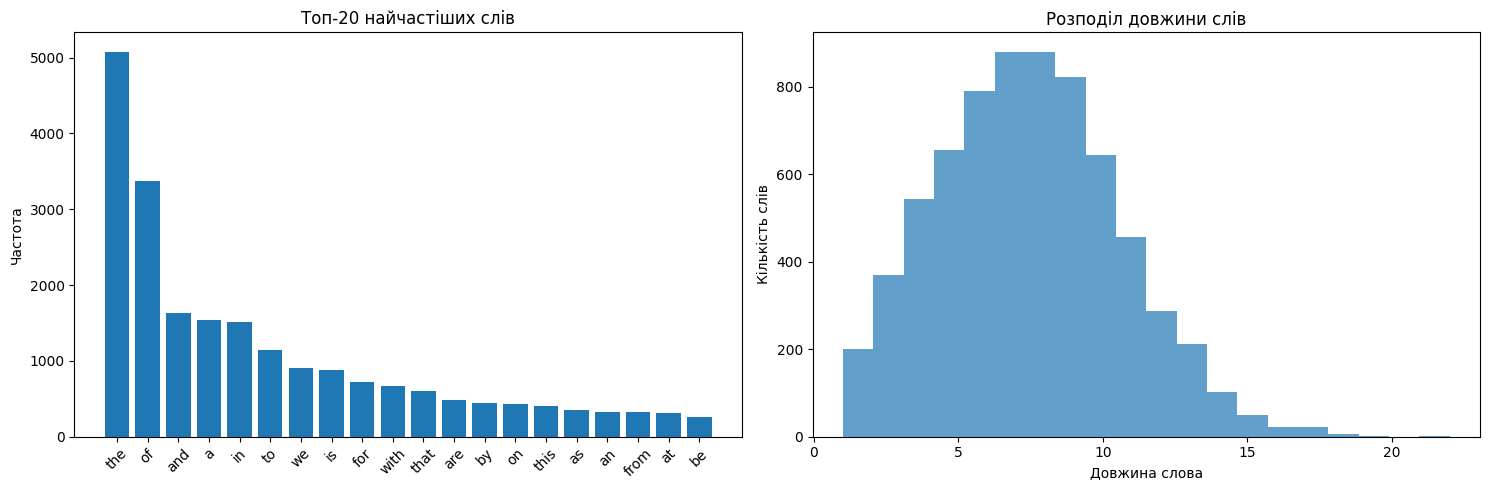


3. Тестування системи автокорекції...

Корекції для 'machien':
  1. machine (ймовірність: 0.000030)

Корекції для 'learing':
  1. leading (ймовірність: 0.000350)
  2. learning (ймовірність: 0.000030)
  3. bearing (ймовірність: 0.000015)

Корекції для 'anaylsis':
  1. analysis (ймовірність: 0.001386)

Корекції для 'artifical':
  1. artificial (ймовірність: 0.000091)

Корекції для 'langauge':
  1. language (ймовірність: 0.000046)

Корекції для 'proces':
  1. process (ймовірність: 0.000426)
  2. probes (ймовірність: 0.000030)
  3. proves (ймовірність: 0.000030)

Корекції для 'computr':
  1. compute (ймовірність: 0.000213)
  2. computer (ймовірність: 0.000122)

Корекції для 'inteligence':
  1. inteligence (ймовірність: 0.000000)

Корекції для 'systm':
  1. system (ймовірність: 0.001356)

Корекції для 'helo':
  1. halo (ймовірність: 0.000198)
  2. help (ймовірність: 0.000107)

4. Тестування мінімальної відстані редагування...

Мінімальна відстань між 'machine' та 'machien': 2
Матриця відст

In [11]:
# Запуск лабораторної роботи
if __name__ == "__main__":
    # Встановлюємо необхідні пакети для Google Colab
    print("Встановлення необхідних пакетів...")
    import subprocess
    import sys

    # Встановлюємо kagglehub якщо його немає
    try:
        import kagglehub
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "kagglehub"])
        import kagglehub

    # Запускаємо лабораторну роботу
    autocorrect_system = run_autocorrect_lab()